# Librerias
---

In [390]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import cv2
from tqdm import tqdm
import os
import glob

# Carga de datos
---

In [478]:
df = pd.read_csv("../../data/train.csv")
df

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


# Análisis exploratorio
---

El dataset contiene las siguientes columnas:
* id: Contiene el caso, el día y el número de imágen.
* segmentation: para algunas imágenes, se describe la mascara que segmenta algun organo en especifico.
* class: Organo que se esta segmentando. 

Usando la funciones basicas de pandas se puede observar que:
* Existen 3 clases, "large_bowel", "small_bowel"  y "stomach", que representan al intestino grueso, intestino delgado, y el estomago respectivamente,
* El dataset contiene 115.488 datos, de los cuales existen 38.496 ids unicos, esto se debe a que para cada imágen hay 3 organos segmentados.
* De los 115.488 datos, solamente 33.913 cuentan con una mascara de segmentación, el resto de datos son NaN.

In [479]:
df.describe()

,id,class,segmentation
count,115488,115488,33913
unique,38496,3,33899
top,case123_day20_slice_0001,large_bowel,12629 10 12894 12 13158 15 13423 17 13688 19 1...
freq,3,38496,2


In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [481]:
df["class"].unique()

array(['large_bowel', 'small_bowel', 'stomach'], dtype=object)

Descomponiendo la información suministrada por el id, se puede encontrar información sobre el número de casos, número de días, y la cantidad de imágenes por cada caso:

Adicionalmente, en el nombre de los archivos se encuentra información sobre el alto y ancho en pixeles, y el espaciado entre pixeles en milimetros.
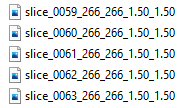
A continuación se extrae la información del tamño y se añade al dataset.

In [482]:
def parse_int(s):
    i = j = 0
    while i < len(s):
        while j < len(s) and s[j].isdigit():
            j += 1
        if i < j:
            return int(s[i:j])
        i = j = j + 1
    return math.nan

def extract_image_info(path):
    case_day, fname = path.rsplit("\\", maxsplit=3)[1::2]
    case, day = case_day.split("_")
    slice, height, width = fname.split("_", maxsplit=4)[1:4]
    info = [f"{case}_{day}_slice_{slice}"]
    numeric_info = [case, day, slice, height, width]
    info.extend([parse_int(info) for info in numeric_info])
    return info
    
def create_image_df(path):
    paths = glob.glob(f"{TRAIN_DIR}/**/*.png", recursive=True)
    df = pd.DataFrame({"path": paths})
    info_cols = ["id", "case", "day", "slice", "height", "width"]
    df[info_cols] = df.apply(
        lambda row: extract_image_info(row.path), 
        axis=1,
        result_type="expand"
    )
    return df

TRAIN_DIR = "../../data/train"
data = create_image_df(TRAIN_DIR)
data

,path,id,case,day,slice,height,width
0,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0001,101,20,1,266,266
1,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0002,101,20,2,266,266
2,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0003,101,20,3,266,266
3,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0004,101,20,4,266,266
4,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0005,101,20,5,266,266
...,...,...,...,...,...,...,...
38491,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0140,92,0,140,266,266
38492,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0141,92,0,141,266,266
38493,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0142,92,0,142,266,266
38494,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0143,92,0,143,266,266


De la siguiente grafica se puede observar que el caso más extenso es el 36, pues este cuente con un mayor número de imágenes. Además, existen casos faltantes que se deben a que el dataset es el destinado a entrenamiento ofrecido por kaggle.

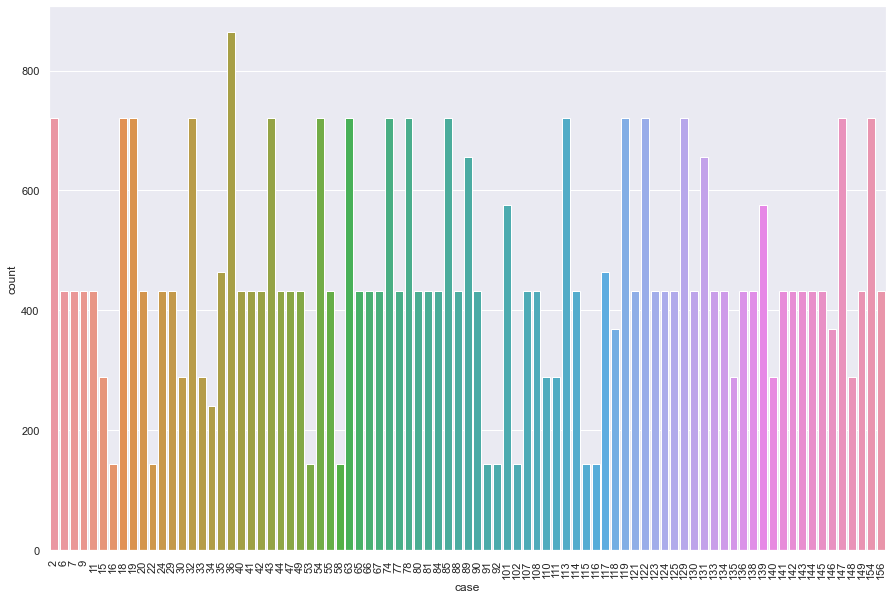

In [483]:
ax = sns.countplot(x="case", data=data)
ax.tick_params(axis='x', rotation=90)

Agrupando el dataset por casos se observa que se cuenta con 156 pacientes junto con la cantidad de días totales

In [484]:
data_case = data.groupby(['case']).max()
data_case

,path,id,day,slice,height,width
case,,,,,,
2,../../data/train\case2\case2_day5\scans\slice_...,case2_day5_slice_0144,5,144,266,266
6,../../data/train\case6\case6_day24\scans\slice...,case6_day24_slice_0144,24,144,360,310
7,../../data/train\case7\case7_day19\scans\slice...,case7_day19_slice_0144,19,144,266,266
9,../../data/train\case9\case9_day22\scans\slice...,case9_day22_slice_0144,22,144,360,310
11,../../data/train\case11\case11_day13\scans\sli...,case11_day13_slice_0144,13,144,360,310
...,...,...,...,...,...,...
147,../../data/train\case147\case147_day20\scans\s...,case147_day20_slice_0144,20,144,360,310
148,../../data/train\case148\case148_day20\scans\s...,case148_day20_slice_0144,20,144,360,310
149,../../data/train\case149\case149_day15\scans\s...,case149_day15_slice_0144,15,144,266,266


De la grafica se observa que los valores más comunes son 0 y 20 días con 9 casos cada uno, segido por 16 días con 8.

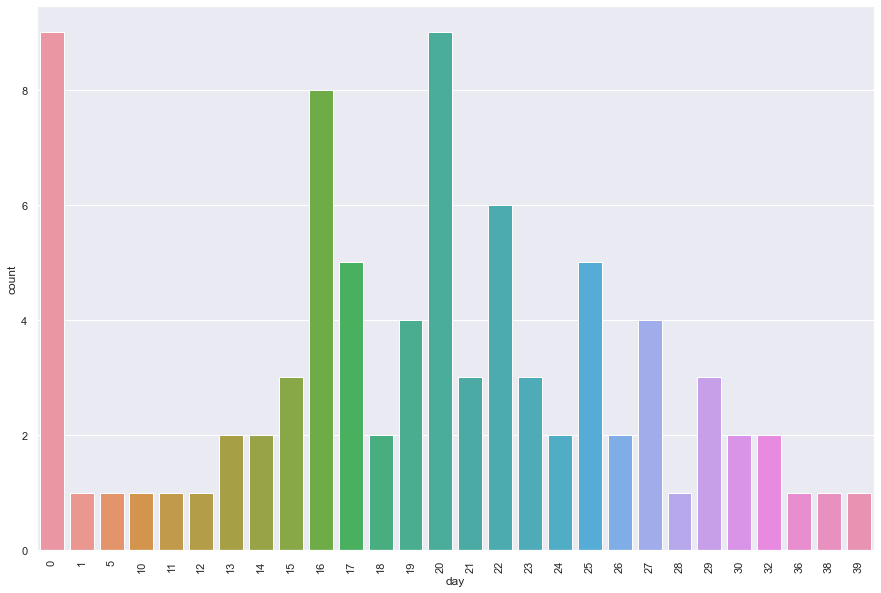

In [485]:
ax = sns.countplot(x="day", data=data_case)
ax.tick_params(axis='x', rotation=90)

En cuanto a la cantidad de imagenes, se observa que la mayoría de casos cuentan con 144 imágenes por día.

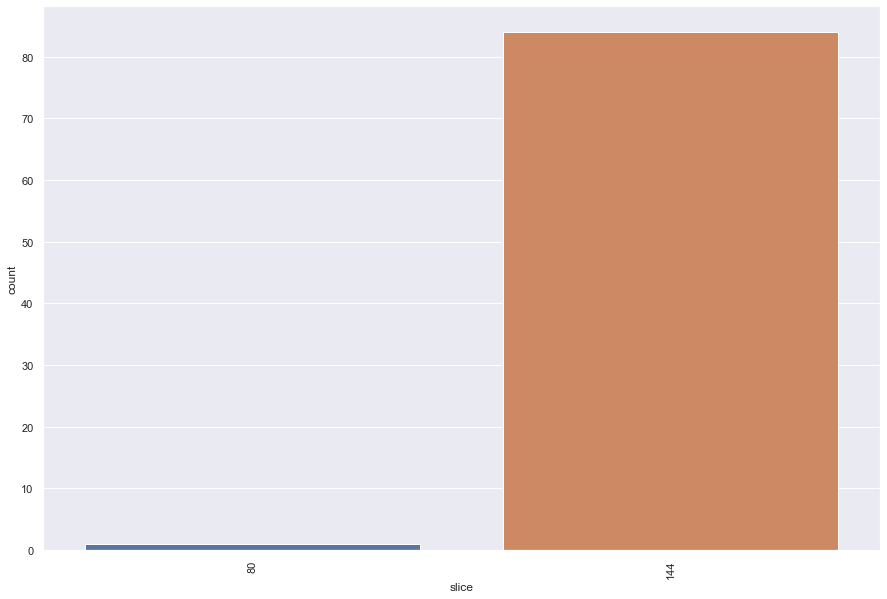

In [486]:
ax = sns.countplot(x="slice", data=data_case)
ax.tick_params(axis='x', rotation=90)

Agrupando el dataset por id, es posible encontrar información sobre las dimenciones de las imágenes.

In [487]:
data_images = data.groupby(['id']).max()
data_images

,path,case,day,slice,height,width
id,,,,,,
case101_day20_slice_0001,../../data/train\case101\case101_day20\scans\s...,101,20,1,266,266
case101_day20_slice_0002,../../data/train\case101\case101_day20\scans\s...,101,20,2,266,266
case101_day20_slice_0003,../../data/train\case101\case101_day20\scans\s...,101,20,3,266,266
case101_day20_slice_0004,../../data/train\case101\case101_day20\scans\s...,101,20,4,266,266
case101_day20_slice_0005,../../data/train\case101\case101_day20\scans\s...,101,20,5,266,266
...,...,...,...,...,...,...
case9_day22_slice_0140,../../data/train\case9\case9_day22\scans\slice...,9,22,140,360,310
case9_day22_slice_0141,../../data/train\case9\case9_day22\scans\slice...,9,22,141,360,310
case9_day22_slice_0142,../../data/train\case9\case9_day22\scans\slice...,9,22,142,360,310


In [488]:
data_images.height.value_counts()

266    25920
360    11232
276     1200
234      144
Name: height, dtype: int64

In [489]:
data_images.width.value_counts()

266    25920
310    11232
276     1200
234      144
Name: width, dtype: int64

Del dataset se observa que hay una misma cantidad de imagenes con determinadas dimensiones, a partir de esto, se puede establecer que los tamaños son:
* 266px x 266px
* 360px x 310px
* 276px x 276px
* 432px x 432px

De las graficas se puede observar que la aproximadamente el tamaño que predomina es de 266px x 266px, seguido por 360px x 310px.

<AxesSubplot:xlabel='width', ylabel='count'>

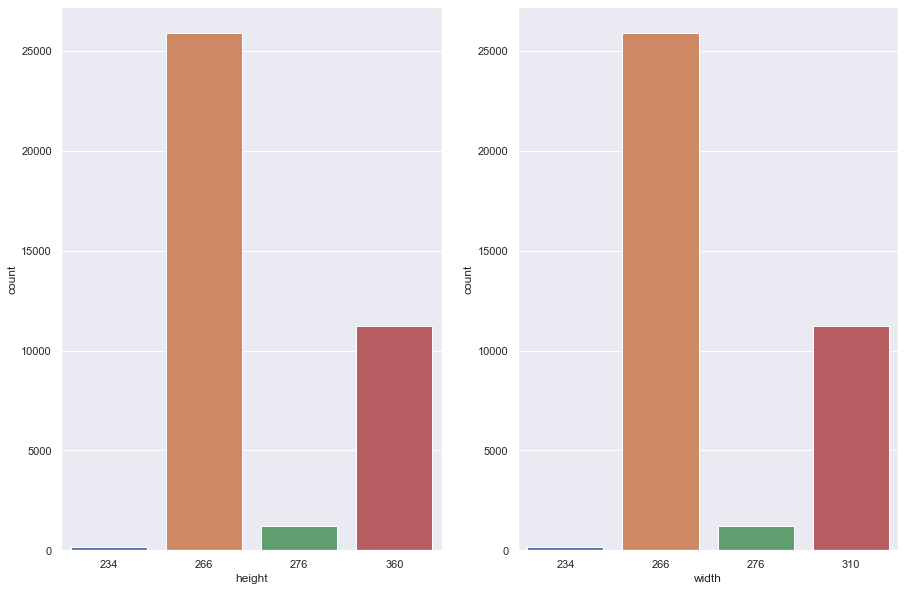

In [490]:
fig, axes = plt.subplots(1, 2)
sns.countplot(ax=axes[0],x="height", data=data_images)
sns.countplot(ax=axes[1],x="width", data=data_images)

Para analizar la segmentación, por facilidad se modifica el dataset para tener ids unicos:

In [491]:
def create_mask_df(df):
    df = df.set_index(["id", "class"]).unstack().reset_index()
    df.columns = "id", 'large_bowel', 'small_bowel', 'stomach'
    df.fillna("", inplace=True)
    return df

segmentation = create_mask_df(df)
data = segmentation.merge(data, on="id", how="left")
data

,id,large_bowel,small_bowel,stomach,path,case,day,slice,height,width
0,case101_day20_slice_0001,,,,../../data/train\case101\case101_day20\scans\s...,101,20,1,266,266
1,case101_day20_slice_0002,,,,../../data/train\case101\case101_day20\scans\s...,101,20,2,266,266
2,case101_day20_slice_0003,,,,../../data/train\case101\case101_day20\scans\s...,101,20,3,266,266
3,case101_day20_slice_0004,,,,../../data/train\case101\case101_day20\scans\s...,101,20,4,266,266
4,case101_day20_slice_0005,,,,../../data/train\case101\case101_day20\scans\s...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,140,360,310
38492,case9_day22_slice_0141,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,141,360,310
38493,case9_day22_slice_0142,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,142,360,310
38494,case9_day22_slice_0143,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,143,360,310


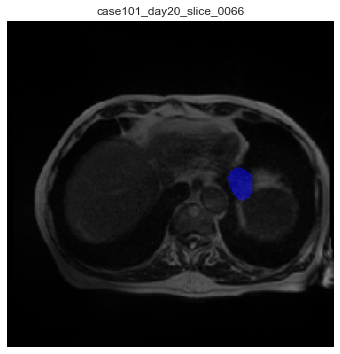

In [494]:
import tensorflow as tf
def tf_rle_decode(mask_rle, orig_shape, output_shape):
    shape = tf.convert_to_tensor(orig_shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, "right")
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    
    # Reshape and resize into mask
    mask = tf.reshape(mask_flat, orig_shape)
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize_with_pad(
        mask,
        *output_shape,
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return tf.cast(mask, tf.uint8)

def tf_load_image(path, output_shape):
    """ Load an image with the resized output shape using only TF
    
    Args:
        path (string): Path to the image to be loaded
        output_shape (tuple, optional): Shape to resize image
    
    Returns:
        3 channel tf.Constant image ready for training/inference
    
    """
    raw = tf.io.read_file(path)
    img = tf.image.decode_png(raw, channels=3, dtype=tf.uint16)
    img = tf.image.resize_with_pad(
        img, 
        *output_shape,
        tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return img

def assemble_masks(lb_seg, sb_seg, s_seg, height, width, output_shape):
    orig_shape = (width, height)  # this ordering is important to decode the rle correctly!
    masks = [
        tf_rle_decode(lb_seg, orig_shape, output_shape),
        tf_rle_decode(sb_seg, orig_shape, output_shape),
        tf_rle_decode(s_seg, orig_shape, output_shape),
    ]
    return tf.concat(masks, axis=-1)
    
def make_dataset(df, output_shape=(224, 224)):
    id_ds = tf.data.Dataset.from_tensor_slices(df.id)
    image_ds = tf.data.Dataset.from_tensor_slices(df.path)
    image_ds = image_ds.map(
        lambda path: tf_load_image(path, output_shape),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    mask_ds = tf.data.Dataset.from_tensor_slices((
        df.large_bowel, 
        df.small_bowel, 
        df.stomach, 
        df.height,
        df.width
    ))
    mask_ds = mask_ds.map(
        lambda *args: assemble_masks(*args, output_shape),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return tf.data.Dataset.zip((id_ds, image_ds, mask_ds))

def show_example(ds):
    for example in ds:
        id, img, mask = example
        if tf.reduce_sum(mask) > 0:
            break
    _, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(id.numpy().decode())
    ax.imshow(tf.keras.utils.array_to_img(img), cmap="gray")
    ax.imshow(tf.keras.utils.array_to_img(mask), cmap="hot", alpha=0.5)
    ax.axis("off")
    plt.show()
    
example_ds = make_dataset(data)
show_example(example_ds)

In [495]:
example_ds

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.uint16, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None))>

In [195]:
img = cv2.imread("../../data/train/case101/case101_day32/scans/slice_0001_266_266_1.50_1.50.png", 0)
img.shape

(266, 266)

In [388]:
img_mean = np.zeros((266, 266))
images = os.listdir("../../data/train/case101/case101_day32/scans/")
total = np.zeros((266, 266))
for image in images:
    img = cv2.imread("../../data/train/case101/case101_day32/scans/" + image, 0)
    print(total.shape)
    print(img.shape)
    total = np.stack((total,img))
total = total /len(images)
plt.figure()
plt.imshow(total)
plt.axis("off")

(266, 266)
(266, 266)
(2, 266, 266)
(266, 266)


ValueError: all input arrays must have the same shape

In [359]:
def get_random_mask(df, n, base_path="../../data/train/"):
    
    for i in range(n):
        sample = df.sample()
        ids = sample.iloc[0,0].split("_")
        path = base_path+ids[0]+"/"+ids[0]+"_"+ids[1]+"/scans/slice_"+ids[3]+"_"+str(sample["height_px"].iloc[0])+"_"+str(sample["width_px"].iloc[0])+"_"+str(sample["height_mm"].iloc[0])+"0_"+str(sample["width_mm"].iloc[0])+"0.png"
        img = cv2.imread(path, 0)     
        print(path)
        sample_seg_list = sample.iloc[0, 2].split()
        start_list = sample_seg_list[0::2]
        length_list = sample_seg_list[1::2]
        
        sample_mask = np.zeros(int(sample["height_px"].iloc[0]) * int(sample["width_px"].iloc[0]), dtype=np.uint8)

        for start, length in zip(start_list, length_list):
            start = int(start)
            length = int(length)
            sample_mask[start:start + length] = 255

        sample_mask = np.reshape(sample_mask, (int(sample["width_px"].iloc[0]), int(sample["height_px"].iloc[0])))
        plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax2.set_title(sample["class"].iloc[0])
        ax1.imshow(img, cmap='viridis')
        ax2.imshow(sample_mask)
        ax3.imshow(img, cmap='viridis')
        ax3.imshow(sample_mask, cmap='viridis', alpha=0.5)
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")

../../data/train/case78/case78_day18/scans/slice_0098_360_310_1.50_1.50.png
../../data/train/case16/case16_day0/scans/slice_0048_360_310_1.50_1.50.png
../../data/train/case130/case130_day20/scans/slice_0056_266_266_1.50_1.50.png
../../data/train/case111/case111_day19/scans/slice_0102_266_266_1.50_1.50.png
../../data/train/case9/case9_day0/scans/slice_0089_360_310_1.50_1.50.png
../../data/train/case19/case19_day22/scans/slice_0096_360_310_1.50_1.50.png
../../data/train/case6/case6_day20/scans/slice_0089_360_310_1.50_1.50.png
../../data/train/case89/case89_day20/scans/slice_0083_266_266_1.50_1.50.png
../../data/train/case122/case122_day0/scans/slice_0108_360_310_1.50_1.50.png
../../data/train/case36/case36_day6/scans/slice_0105_266_266_1.50_1.50.png


<Figure size 1080x720 with 0 Axes>

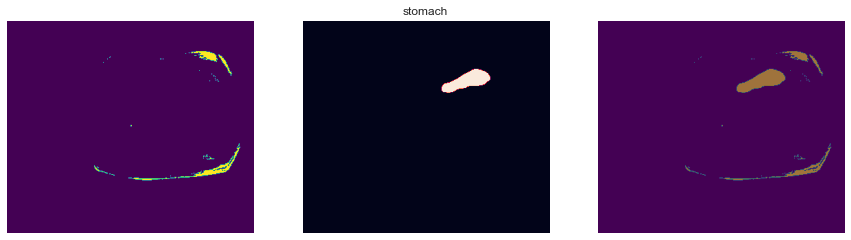

<Figure size 1080x720 with 0 Axes>

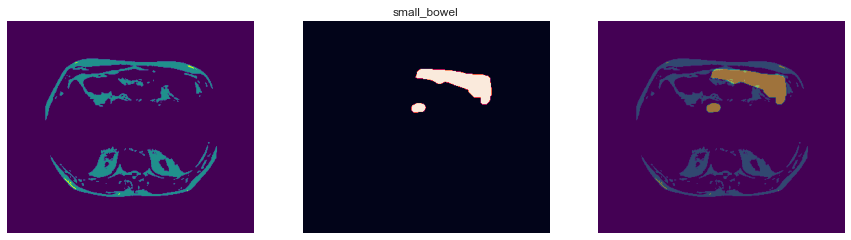

<Figure size 1080x720 with 0 Axes>

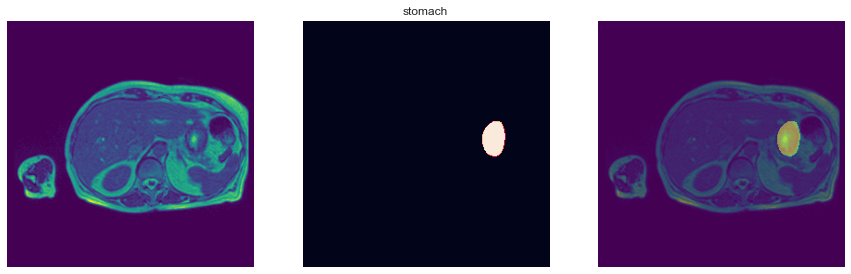

<Figure size 1080x720 with 0 Axes>

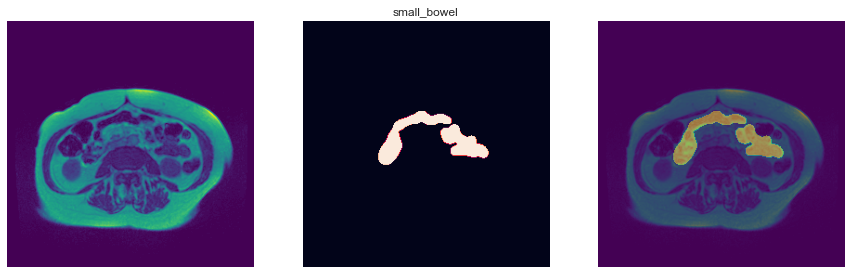

<Figure size 1080x720 with 0 Axes>

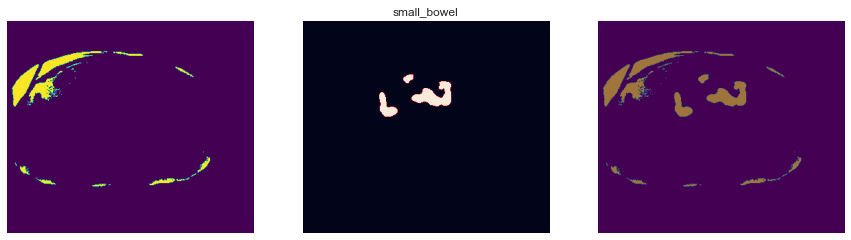

<Figure size 1080x720 with 0 Axes>

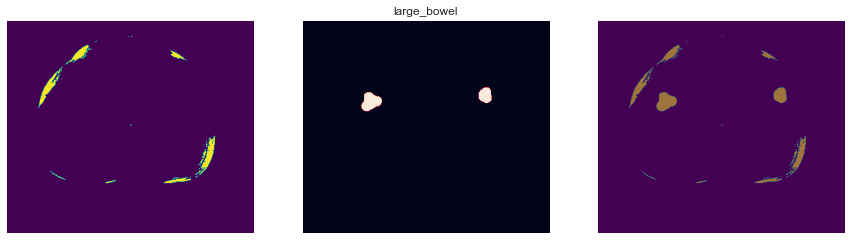

<Figure size 1080x720 with 0 Axes>

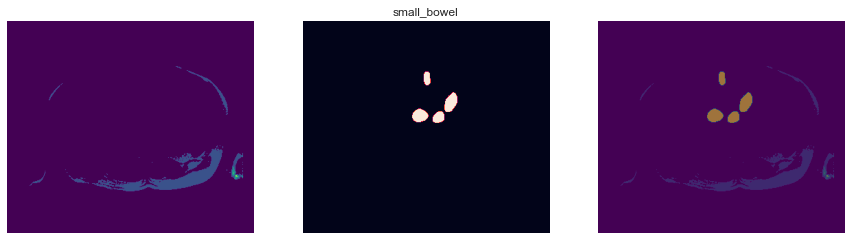

<Figure size 1080x720 with 0 Axes>

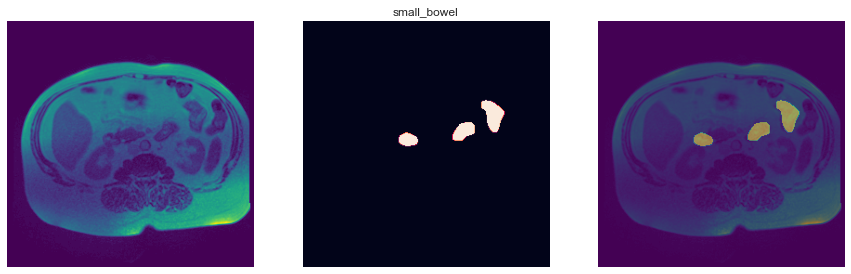

<Figure size 1080x720 with 0 Axes>

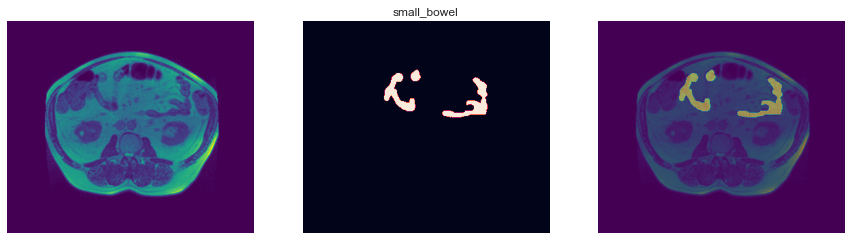

<Figure size 1080x720 with 0 Axes>

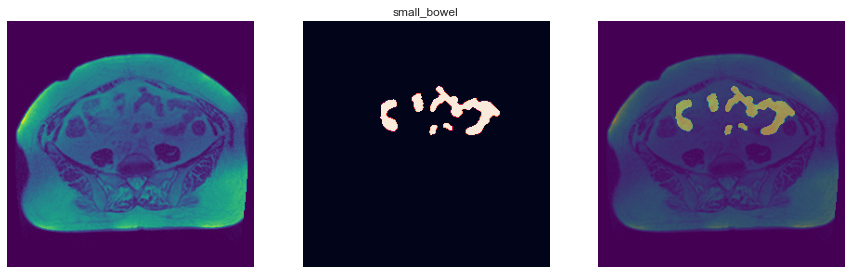

In [360]:
import matplotlib.pyplot as pls
get_random_mask(segmentation, 10)

(array([  0, 255], dtype=uint8), array([331287,   3513], dtype=int64))

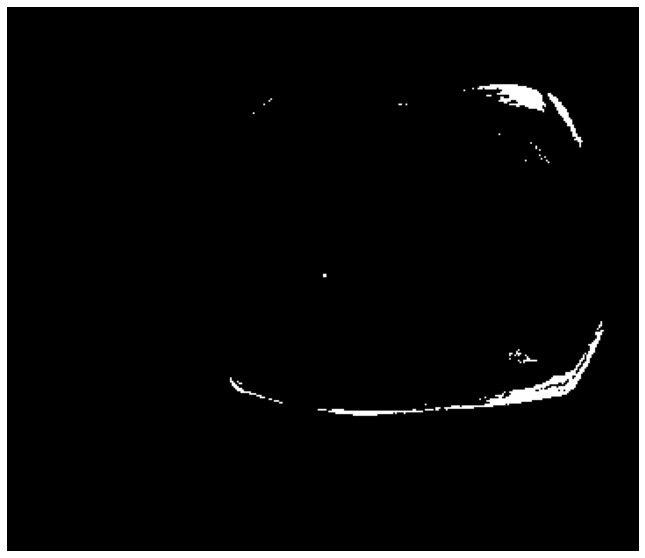

In [377]:
img = cv2.imread("../../data/train/case78/case78_day18/scans/slice_0098_360_310_1.50_1.50.png")
img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
plt.imshow(img, cmap="viridis")
plt.axis("off")
np.unique(img, return_counts=True)


In [200]:
segmentation = data.dropna().reset_index(drop=True)
segmentation

,id,class,segmentation,case,day,slice,height_px,width_px,height_mm,width_mm
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,266,266,1.5,1.5
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,266,266,1.5,1.5
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,266,266,1.5,1.5
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,266,266,1.5,1.5
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,266,266,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...
33908,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,30,0,0135,266,266,1.5,1.5
33909,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...,30,0,0136,266,266,1.5,1.5
33910,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,30,0,0136,266,266,1.5,1.5
33911,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,30,0,0137,266,266,1.5,1.5


In [343]:
segmentation[segmentation["case"]==123]

,id,class,segmentation,case,day,slice,height_px,width_px,height_mm,width_mm
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,266,266,1.5,1.5
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,266,266,1.5,1.5
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,266,266,1.5,1.5
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,266,266,1.5,1.5
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,266,266,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...
370,case123_day0_slice_0111,small_bowel,13701 9 13966 12 14231 14 14496 16 14761 18 15...,123,0,0111,266,266,1.5,1.5
371,case123_day0_slice_0112,large_bowel,25480 7 25744 11 26008 15 26274 16 26539 18 26...,123,0,0112,266,266,1.5,1.5
372,case123_day0_slice_0112,small_bowel,13702 7 13966 11 14231 13 14496 15 14762 16 15...,123,0,0112,266,266,1.5,1.5
373,case123_day0_slice_0113,large_bowel,25480 6 25744 10 26008 14 26273 16 26539 17 26...,123,0,0113,266,266,1.5,1.5


In [344]:
data[data["case"]==123]

,id,class,segmentation,case,day,slice,height_px,width_px,height_mm,width_mm
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,266,266,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...
1291,case123_day0_slice_0143,small_bowel,NaN,123,0,0143,266,266,1.5,1.5
1292,case123_day0_slice_0143,stomach,NaN,123,0,0143,266,266,1.5,1.5
1293,case123_day0_slice_0144,large_bowel,NaN,123,0,0144,266,266,1.5,1.5
1294,case123_day0_slice_0144,small_bowel,NaN,123,0,0144,266,266,1.5,1.5
